In [1]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset, concatenate_datasets
import os
import json
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split 


## Import the dataset

In [2]:

df_path = "../../../eHRAF_Scraper-Analysis-and-Prep/Data/"
dataFolder = r"(subjects-(contracts_OR_disabilities_OR_disasters_OR_friendships_OR_gift_giving_OR_infant_feeding_OR_lineages_OR_local_officials_OR_luck_and_chance_OR_magicians_and_diviners_OR_mortuary_specialists_OR_nuclear_family_OR_priesthood_OR_prophet/"
# dataFolder = r'subjects-(sickness)_FILTERS-culture_level_samples(PSF)'

# Get model and centralized path if relevent
model_name = "HRAF_MultiLabel_Hierarchical"
path = f"" #Path to centralized file locations (leave blank if centralized location is here)



#load df
df = pd.read_excel(f"{df_path}{dataFolder}/_Altogether_Dataset_RACoded_Combined.xlsx", header=[0,1], index_col=0) # Spring 2023 - Spring 2024  sickness + nonsickness dataset
df.head(3)

CULTURE                               \
  Passage Number Region   SubRegion   Culture   
0           1392   Asia  South Asia  Andamans   
1           1393   Asia  South Asia  Andamans   
2           1395   Asia  South Asia  Andamans   

                                                                     \
                                            DocTitle        Section   
0  Hygiene and medical practices among the Onge (...  1. Habitation   
1  Hygiene and medical practices among the Onge (...        3. Food   
2  Hygiene and medical practices among the Onge (...        3. Food   

                               \
            Author Page  Year   
0  Cipriani, Lidio  484  1961   
1  Cipriani, Lidio  487  1961   
2  Cipriani, Lidio  490  1961   

                                                      ... ACTION  \
                                                 OCM  ...  Other   
0  ['171', '301', '727', '751', '765', '775', '777']  ...      1   
1  ['136', '231', '271', '312', '415', '516', '751']  ...      0   
2  ['114', '137', '164', '262', '273', '751', '825']  ...      0   

                                                      \
                                         Description   
0  Several customs are believed to connect with t...   
1                             No action is mentioned   
2  Certain foods, such as Pteropus (giant bat) an...   

                                                      \
                                         Local_terms   
0   ibidanghe: made from decorated human jawbone ...   
1                                                  0   
2  Pteropus: a giant bat  eaten by the Andaman Is...   

                                               OTHER      CODER           \
                                      Other_Comments Run_Number Finished   
0  General note of this spreadsheet - many of the...          1     True   
1                                                NaN          1     True   
2                                                NaN          1     True   

                   OTHER   CODER  \
  Coder Other_Comments.1 Dataset   
0    YM              NaN       1   
1    YM              NaN       1   
2    YM              NaN       1   

                                                      
                                                Info  
0  Dataset 1: ['750', '751', '752', '753']   Coun...  
1  Dataset 2: ['784', '731', '732', '777', '791',...  
2  Run 1: Spring 2023 Coding of Sickness dataset ...  

[3 rows x 43 columns]

## Preprocess

### Remove Duplicates

There were multiple iterations of Research Assistants labeling the data. <br>
We will just use run number 1 and 3 with preference to 3 when there are duplicates (as it is the most recent and robust)


In [3]:
# Show run number and dataset
df["CODER"][["Run_Number", "Dataset"]].value_counts(sort=False, dropna=False)

Run_Number  Dataset
1           1          1926
2           1            51
3           1          4844
            2          4184
Name: count, dtype: int64

In [4]:

mask_NotDuplicate = ~(df.duplicated(("CULTURE","Passage"), keep=False)) 
mask_Dataset2 = df[("CODER","Run_Number")]==3


df = df[(mask_NotDuplicate) |  (mask_Dataset2)]
print("Duplicate Passages:",sum((df.duplicated(("CULTURE","Passage")))))
df[("CODER","Run_Number")].value_counts()

Duplicate Passages: 0


(CODER, Run_Number)
3    9028
1    1340
Name: count, dtype: int64

### Set up Dataset


In [5]:
#Construct col list
cols = list(df.columns)
id_index = cols.index(('CULTURE', "Passage Number"))
passage_index = cols.index(('CULTURE', "Passage"))
event_index =  cols.index(('EVENT', "No_Info"))
cause_index = cols.index(('CAUSE', "No_Info"))
action_index = cols.index(('ACTION', "No_Info"))

# get a list of all the multi-indexed column names we want to evaluate
col_list = [cols[id_index]] + [cols[passage_index]] + cols[event_index:event_index+4] + cols[cause_index:cause_index+7] + cols[action_index:action_index+7] #to include all columns including No_info


# get column names to ascribe to the new data frame
colNames = ["ID","passage"]
for category, sub_cat in col_list:
    # skip passage and id which have already been added
    # print(category, sub_cat)
    if category == "CULTURE":
        continue
    if sub_cat == "No_Info":
        colNames += [category]#this to include main classes, we will hold off on that
        pass
    else:
        colNames += [f'{category}_{sub_cat}']

print("Columns excluded:\n", set(cols)-set(col_list),"\n")
# for col in col_list
print("Columns included:")
for col in colNames:
    print(col)
# colNames


Columns excluded:
 {('ACTION', 'Description'), ('CULTURE', 'Region'), ('CULTURE', 'Section'), ('CODER', 'Dataset'), ('CULTURE', 'Author'), ('OTHER', 'Other_Comments'), ('OTHER', 'Other_Comments.1'), ('CULTURE', 'DocTitle'), ('CODER', 'Coder'), ('CAUSE', 'Local_Terms'), ('CAUSE', 'Description'), ('ACTION', 'Local_terms'), ('CULTURE', 'OCM'), ('CODER', 'Run_Number'), ('CODER', 'Finished'), ('EVENT', 'Local_Terms'), ('EVENT', 'Description'), ('CULTURE', 'Year'), ('CULTURE', 'OWC'), ('CULTURE', 'Culture'), ('CULTURE', 'SubRegion'), ('CULTURE', 'Page'), ('CODER', 'Info')} 

Columns included:
ID
passage
EVENT
EVENT_Illness
EVENT_Accident
EVENT_Other
CAUSE
CAUSE_Just_Happens
CAUSE_Material_Physical
CAUSE_Spirits_Gods
CAUSE_Witchcraft_Sorcery
CAUSE_Rule_Violation_Taboo
CAUSE_Other
ACTION
ACTION_Physical_Material
ACTION_Technical_Specialist
ACTION_Divination
ACTION_Shaman_Medium_Healer
ACTION_Priest_High_Religion
ACTION_Other


### Create Huggingface Dataset and do splits

In [ ]:
# subdivide into just passage and outcome
df_small = pd.DataFrame()
df_small[colNames] = df[col_list]
# Flip the label of "no_info" to follow sub label's Present=1 Absent=0
df_small[["EVENT","CAUSE","ACTION"]]  = df_small[["EVENT","CAUSE","ACTION"]].replace({0:1, 1:0})

# Remove certain passages which should not be in training or inference (these are duplicates that had to be manually found by a human)
values_to_remove = [3252, 33681, 6758, 10104]
df_small = df_small[~df_small['ID'].isin(values_to_remove)]

# create train and validation/test sets
train_val, test = train_test_split(df_small, test_size=0.20, random_state=10)


# Create an NLP friendly dataset
Hraf = DatasetDict(
    {'train':Dataset.from_dict(train_val.to_dict(orient= 'list')),
     'test':Dataset.from_dict(test.to_dict(orient= 'list'))})
Hraf

DatasetDict({
    train: Dataset({
        features: ['ID', 'passage', 'EVENT', 'EVENT_Illness', 'EVENT_Accident', 'EVENT_Other', 'CAUSE', 'CAUSE_Just_Happens', 'CAUSE_Material_Physical', 'CAUSE_Spirits_Gods', 'CAUSE_Witchcraft_Sorcery', 'CAUSE_Rule_Violation_Taboo', 'CAUSE_Other', 'ACTION', 'ACTION_Physical_Material', 'ACTION_Technical_Specialist', 'ACTION_Divination', 'ACTION_Shaman_Medium_Healer', 'ACTION_Priest_High_Religion', 'ACTION_Other'],
        num_rows: 518
    })
    test: Dataset({
        features: ['ID', 'passage', 'EVENT', 'EVENT_Illness', 'EVENT_Accident', 'EVENT_Other', 'CAUSE', 'CAUSE_Just_Happens', 'CAUSE_Material_Physical', 'CAUSE_Spirits_Gods', 'CAUSE_Witchcraft_Sorcery', 'CAUSE_Rule_Violation_Taboo', 'CAUSE_Other', 'ACTION', 'ACTION_Physical_Material', 'ACTION_Technical_Specialist', 'ACTION_Divination', 'ACTION_Shaman_Medium_Healer', 'ACTION_Priest_High_Religion', 'ACTION_Other'],
        num_rows: 9849
    })
})

Make sure the train, validation, and test sets are as biased as our total input data (we want each to match more or less with the total) <br>

In [7]:
# extract the total proportion
def totalProportion(df, col, present=1):
    value_counts = df[col].value_counts()
    percentage = round(value_counts[present]/len(df)*100,2)
    return percentage

# extracts percentages per datafaframe
def colProportion(Hraf, col):
    percentage_list = []
    for dataframe in Hraf.keys():
        percentage_list += [round(sum(Hraf[dataframe][col]) / (len(Hraf[dataframe]))*100,2)]
    return percentage_list



# print bias per label
dataframe_keys= Hraf.keys()
labels = [label for label in Hraf['train'].features.keys() if label not in ['ID', 'passage']]
header = "                                TOTAL"
for key in dataframe_keys:
    header += f"     {key}"
print(header)
print('_'*(len(header)+4))
for col in labels:
    totalPercentage =  totalProportion(df_small, col)
    percentage_list =  colProportion(Hraf, col)
    spacing = 10
    percentage_str = f"{totalPercentage}{' '* (spacing-len(str(totalPercentage)))}"
    for index, key in enumerate(dataframe_keys):
        percentage_str += f"{(len(key)-5)*' '}{percentage_list[index]}{' '* (spacing-len(str(percentage_list[index])))}"
    print(f"{col}:{' ' * (30- len(col))} {percentage_str}")

                                TOTAL     train     test
____________________________________________________________
EVENT:                          63.22     61.0      63.34     
EVENT_Illness:                  40.58     41.89     40.51     
EVENT_Accident:                 6.56      6.37      6.57      
EVENT_Other:                    26.04     22.59     26.23     
CAUSE:                          46.54     46.91     46.52     
CAUSE_Just_Happens:             2.37      1.54      2.42      
CAUSE_Material_Physical:        17.04     17.95     17.0      
CAUSE_Spirits_Gods:             18.72     18.53     18.73     
CAUSE_Witchcraft_Sorcery:       6.33      7.14      6.28      
CAUSE_Rule_Violation_Taboo:     10.19     10.23     10.18     
CAUSE_Other:                    5.28      5.02      5.29      
ACTION:                         47.66     45.37     47.78     
ACTION_Physical_Material:       32.21     30.89     32.28     
ACTION_Technical_Specialist:    6.9       7.34      6.87      


Create labels for training and preprocessing

In [8]:

labels = [label for label in Hraf['train'].features.keys() if label not in ['ID', 'passage']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
id2label

{0: 'EVENT',
 1: 'EVENT_Illness',
 2: 'EVENT_Accident',
 3: 'EVENT_Other',
 4: 'CAUSE',
 5: 'CAUSE_Just_Happens',
 6: 'CAUSE_Material_Physical',
 7: 'CAUSE_Spirits_Gods',
 8: 'CAUSE_Witchcraft_Sorcery',
 9: 'CAUSE_Rule_Violation_Taboo',
 10: 'CAUSE_Other',
 11: 'ACTION',
 12: 'ACTION_Physical_Material',
 13: 'ACTION_Technical_Specialist',
 14: 'ACTION_Divination',
 15: 'ACTION_Shaman_Medium_Healer',
 16: 'ACTION_Priest_High_Religion',
 17: 'ACTION_Other'}

### Tokenize Data

load a DistilBERT tokenizer to preprocess the text field: <br>

Create a preprocessing function to tokenize text and truncate sequences to be no longer than DistilBERT’s maximum input length:<br>
Guidelines were followed from NielsRogge found <a href= "https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb"> here </a>

In [9]:
from transformers import AutoTokenizer



# divide labels into categories for later training
labels_dict = dict()
main_labels = ["EVENT","CAUSE","ACTION"]
labels_dict['main_labels'] = main_labels
for main_label in main_labels:
    main_label_text = main_label.lower()+'_labels'
    labels_dict[main_label_text] = [x for x in labels if x.startswith(main_label+'_')]
# Get tiered labels potentially for later custom_trainer recognization
tieredLabels = list(labels_dict.keys())


tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def preprocess_data(examples):
  # take a batch of texts
  text = examples["passage"]
  # encode them
  encoding = tokenizer(text, max_length=512, truncation=True) #max length for BERT is 512
  # add labels
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}

  # LABELING Hierarchical machine learning label ascription
  for label_category, label_list in labels_dict.items():
    # create numpy array of shape (batch_size, num_labels)
    labels_matrix = np.zeros((len(text), len(label_list)))
    # fill numpy array
    for idx, label in enumerate(label_list):
      labels_matrix[:, idx] = labels_batch[label]
    encoding[label_category] = labels_matrix.tolist()

  return encoding

To apply the preprocessing function over the entire dataset, use 🤗 Datasets map function. You can speed up map by setting batched=True to process multiple elements of the dataset at once:

In [10]:
# Tokenize data, remove all columns and give new ones
tokenized_Hraf = Hraf.map(preprocess_data, batched=True, remove_columns=Hraf['train'].column_names)

Map:   0%|          | 0/518 [00:00<?, ? examples/s]

Map:   0%|          | 0/9849 [00:00<?, ? examples/s]

In [11]:
# Set tokenized passages to PyTorch Tensor
tokenized_Hraf.set_format("torch")
tokenized_Hraf

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'main_labels', 'event_labels', 'cause_labels', 'action_labels'],
        num_rows: 518
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'main_labels', 'event_labels', 'cause_labels', 'action_labels'],
        num_rows: 9849
    })
})

Now create a batch of examples using <a href="https://huggingface.co/docs/transformers/v4.29.0/en/main_classes/data_collator#transformers.DataCollatorWithPadding"> DataCollatorWithPadding</a>. It’s more efficient to dynamically pad the sentences to the longest length in a batch during collation, instead of padding the whole dataset to the maximum length.

### Create KFolds Splits

 Stratification using multilabels is a difficult process as the number of unique bins of stratification increases exponentially by the number of labels (see more info and potential ways to conduct multilabel sttratification sampling <a href="https://dl.acm.org/doi/10.5555/2034161.2034172"> HERE  </a>). We will currently disregard focusing on stratification of all the labels/classifications and just use a single label for stratification. Currently, this is still giving decent splits that do not deviate far from the true proportion or between n_splits. Still, one should check the proportional deviation of each label to make sure

In [27]:
#  Splitting
from sklearn.model_selection import StratifiedKFold
fold_n =5

# folds = StratifiedKFold(n_splits=5)
folds = StratifiedKFold(n_splits=fold_n, shuffle= True, random_state=10)
cols = Hraf['train'].column_names
splits = folds.split(np.zeros(Hraf['train'].num_rows), Hraf['train'][cols[-1]])
# preconstruct dataframe to show
fold_str = ["Fold "+str(x) for x in range(1,fold_n+1)]
df_foldPerc = pd.DataFrame(data=np.zeros((fold_n,len(labels))),columns=labels, index=fold_str)

train_list = []
val_list = []

for fold, (train_idxs, val_idxs) in enumerate(splits, start=1):
    train_list += [train_idxs]
    val_list += [val_idxs]
    train_hub = Hraf['train'][train_idxs]

    df_foldPerc.iloc[fold-1] = [np.round(np.mean(train_hub[col]),2) for col in cols[2:]]
    
df_foldPerc

,EVENT,EVENT_Illness,EVENT_Accident,EVENT_Other,CAUSE,CAUSE_Just_Happens,CAUSE_Material_Physical,CAUSE_Spirits_Gods,CAUSE_Witchcraft_Sorcery,CAUSE_Rule_Violation_Taboo,CAUSE_Other,ACTION,ACTION_Physical_Material,ACTION_Technical_Specialist,ACTION_Divination,ACTION_Shaman_Medium_Healer,ACTION_Priest_High_Religion,ACTION_Other
Fold 1,0.61,0.41,0.07,0.22,0.46,0.02,0.17,0.18,0.07,0.10,0.06,0.45,0.31,0.07,0.02,0.06,0.04,0.06
Fold 2,0.61,0.43,0.06,0.22,0.47,0.01,0.17,0.20,0.06,0.10,0.05,0.47,0.32,0.07,0.02,0.06,0.04,0.06
Fold 3,0.63,0.43,0.07,0.24,0.49,0.02,0.18,0.19,0.08,0.11,0.05,0.45,0.29,0.07,0.02,0.07,0.03,0.06
Fold 4,0.60,0.41,0.07,0.22,0.45,0.01,0.19,0.17,0.07,0.10,0.05,0.45,0.31,0.07,0.02,0.06,0.04,0.06
Fold 5,0.61,0.42,0.05,0.22,0.47,0.02,0.18,0.19,0.07,0.10,0.04,0.46,0.31,0.08,0.01,0.07,0.04,0.06


### Save Paritioned Datasets

In [15]:
# Save datasets for later inference (SKIP IF YOU DO NOT WANT TO OVERWRITE DATASET FILES)

def make_dir(path):
    import os
    # Check whether the specified path exists or not
    isExist = os.path.exists(path)
    if not isExist:
    # Create a new directory because it does not exist
        os.makedirs(path)

# make folder if it does not exist yet
path_datasets = os.getcwd() + '/Datasets'
make_dir(path_datasets)
# save to Json
for key in Hraf.keys():
    Hraf_dict = Hraf[key].to_dict()
    file_path = f"{path_datasets}/{key}_dataset.json"
    with open(file_path, "w") as outfile:
        json.dump(Hraf_dict, outfile)
        print(len(Hraf_dict['ID']), f"Rows for \'{key}\' succesfully saved to {file_path}")

8293 Rows for 'train' succesfully saved to /Users/ericchantland/Library/CloudStorage/Dropbox/MEM-DEV-LAB-Current/2023-eHRAF-Misf/HRAF-Misf-NaturalLanguageProcessing/HRAF_NLP/HRAF_MultiLabel_Hierarchical/Datasets/train_dataset.json
2074 Rows for 'test' succesfully saved to /Users/ericchantland/Library/CloudStorage/Dropbox/MEM-DEV-LAB-Current/2023-eHRAF-Misf/HRAF-Misf-NaturalLanguageProcessing/HRAF_NLP/HRAF_MultiLabel_Hierarchical/Datasets/test_dataset.json


## Evaluate

Obtain F1 score for evaluation

In [28]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction, TrainerCallback
import torch

# # Get Metric performance (updated for hierarchical)
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    
    # finally, compute metrics
    # Handle potential 1D label format
    if labels.ndim == 1:
        y_true = np.zeros((len(labels), y_pred.shape[1]))
        for i, label_indices in enumerate(labels):
            y_true[i, label_indices] = 1
    else:
        y_true = labels 

    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

# # Compute evaluation
def compute_metrics(p: EvalPrediction):

    main_preds, event_preds, cause_preds, action_preds = p.predictions 

    # Calculate overall F1 micro score including eaach individual label (Note, this is probably not the best method for training but is currently a stand in) 
    preds = np.concatenate(p.predictions, axis=1)
    label_ids = np.concatenate(p.label_ids, axis=1)
    result = multi_label_metrics(
        predictions=preds, 
        labels=label_ids)

    #Calculate individual F1 scores for each category
    result['main_metrics'] = multi_label_metrics(predictions=main_preds, labels=p.label_ids[0]) 
    result['event_metrics'] = multi_label_metrics(predictions=event_preds, labels=p.label_ids[1])
    result['cause_metrics'] = multi_label_metrics(predictions=cause_preds, labels=p.label_ids[2])
    result['action_metrics'] = multi_label_metrics(predictions=action_preds, labels=p.label_ids[3])

    #Get Loss from latest loss calculation
    result['main_metrics']['loss'] = float(trainer.main_loss)
    result['event_metrics']['loss'] = float(trainer.event_loss)
    result['cause_metrics']['loss'] = float(trainer.cause_loss)
    result['action_metrics']['loss'] = float(trainer.action_loss)


    return result



## Train

### Save Functions for Saving Training Results

In [46]:
# Save evaluation dataframe
def eval_save(eval_df, directory="", overwrite_training=True):
    # Augment Evaluation File 
    from datetime import date

    file_path = f"{directory}/Evaluation.xlsx"

    today = date.today()
    date_tm = today.strftime("%y/%m/%d")

    #reorganize columns
    cols = list(eval_df.columns.values) 
    remove_list = ["fold", "epoch","weight_decay", "learning_rate"]
    for removal in remove_list:
        cols.remove(removal)
    cols = remove_list+cols
    eval_df = eval_df[cols]


    trainingStatus = 'Initial Training' if overwrite_training == True else 'Continue Training'

    info_df  = pd.DataFrame({"Date":len(eval_df)*[date_tm],"Train_status":len(eval_df)*[trainingStatus]})
    eval_df = eval_df.reset_index(drop=True)
    eval_df = pd.concat([info_df, eval_df], axis=1)

    # import evaluation if it exists
    if os.path.exists(file_path):
        old_eval = pd.read_excel(file_path, sheet_name="Sheet1", index_col=0)
        eval_df = pd.concat([old_eval, eval_df])

    eval_df.to_excel(file_path)

# combine the history output the model gives into a more digestable list format within a dictionary for val and train
def epochDictCreator(history_list:list) -> dict:
    epochHistory = dict() 

    #get train and Val and put them in a dictionary
    for train_or_val in ["train","val"]:
        if train_or_val== 'val':
            epochHistory_list = [x for x in history_list if (x.get("eval_loss", 'a') !='a')] # get only validation epochs (will have eval_loss)
        elif train_or_val == 'train':
            epochHistory_list = [x for x in history_list if (x.get("loss", 'a') !='a')] # get only training epochs (will have loss and typically the epoch will be a non-integer)
        else:
            raise Exception("Must enter train or val")
        # Create dictionary of values for val or train
        epochHistory_dict = dict()
        count=0
        for epoch in epochHistory_list:
            if count == 0:
                epochHistory_dict = {key:[val] for key, val in epoch.items()}
            else:
                for key, val in epoch.items():
                    try:
                        epochHistory_dict[key].append(val)
                    except:
                        print("train or Val:",train_or_val,"Count:", count)
            count +=1
        epochHistory[train_or_val] = epochHistory_dict
    return epochHistory

# save epoch dicts to a file (append if already exists)
def epochDictSave(directory, History_list:list):
    import json
    import os
    directory = f"{directory}/HistoryLog.json"
    if os.path.exists(directory):
        with open(directory, 'r') as openfile:
            oldHistory = json.load(openfile)
            History_list = oldHistory+History_list
            
    with open(directory, "w") as outfile:
        json.dump(History_list, outfile, indent=4)
        # outfile.write(json_object)

# Create Parameter JSON file
def saveParam(output_dir, param_dict:dict):
    import json
    import os
    # Check if param file already exists, if so, warn the user.
    if os.path.exists(f"{output_dir}/Model_Params.json"):
        print('\033[91m'+ "WARNING model parameter file overwritten" + '\033[0m')
        with open(f"{output_dir}/Model_Params.json", "r") as openfile:
            oldParam = json.load(openfile)
            flag = 0
            for key, val in param_dict.items():
                try:
                    if oldParam[key] != val:
                        flag = 1
                        print(f"{key}: {oldParam[key]} != {val}")
                except:
                    print(f"{key} not found in old file")
            if flag == 0:
                print("All parameters match")
    # save file
    with open(f"{output_dir}/Model_Params.json", "w") as outfile:
        json.dump(param_dict, outfile)
# create descending folders, give list of folders from parent to lowest child
def createFolders(paths:list):
    current_path = ""
    for path in paths:
        if len(path) == 0 or path == '/': # Skip blank paths (here to work with both google colab and vscode local notebooks)
            continue
        current_path += f"{path}/"
        os.mkdir(current_path) if not os.path.exists(current_path) else None

### Model Initialization

In [47]:
# test for hierarchical forward pass using Huggingface


import torch
import torch.nn as nn
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding, DistilBertModel




# Define the custom classifier for sub-labels
class SubLabelClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SubLabelClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)    ## Linear is a simple linear transformation layer
        self.fc2 = nn.Linear(hidden_dim, output_dim)  
        self.dropout = nn.Dropout(0.1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# Create sample model
class HierarchicalMultiLabelClassifier(nn.Module):
    def __init__(self, model_name, num_main_labels, num_event_labels, num_cause_labels, num_action_labels):
        super(HierarchicalMultiLabelClassifier, self).__init__()
        # Not sure the purpose of these here, maybe a fluke with GPT or is for later reference donw the line, probably not needed here
        self.num_main_labels = num_main_labels
        self.num_event_labels = num_event_labels
        self.num_cause_labels = num_cause_labels
        self.num_action_labels = num_action_labels
        
        # self.distilbert = DistilBertForSequenceClassification.from_pretrained(model_name) 
        self.distilbert = DistilBertModel.from_pretrained(model_name) # This does not use the head for sequence classification, I am wondering if that is a disadvantage
        hidden_size = self.distilbert.config.hidden_size
        
        # logits for each classifier group (might only need main and sublabel groups...)
        self.main_classifier = nn.Linear(hidden_size, num_main_labels)
        self.event_classifier = SubLabelClassifier(input_dim = self.distilbert.config.hidden_size, hidden_dim = 50, output_dim = num_event_labels)
        self.cause_classifier = SubLabelClassifier(input_dim = self.distilbert.config.hidden_size, hidden_dim = 50, output_dim = num_cause_labels)
        self.action_classifier = SubLabelClassifier(input_dim = self.distilbert.config.hidden_size, hidden_dim = 50, output_dim = num_action_labels)
        #
    def forward(self, input_ids, attention_mask): #(should the argument params be "tensor" instead like the huggingface example?)
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs[0]  # Last hidden state
        pooled_output = hidden_state[:, 0]  # [CLS] token
        
        main_logits = self.main_classifier(pooled_output)
        event_logits = self.event_classifier(pooled_output) #previously outputs.last_hidden_state as per chat gpt. It was changed also because of chat GPT but also because the sizes of the logits and the labels did not match 
        cause_logits = self.cause_classifier(pooled_output)
        action_logits = self.action_classifier(pooled_output)
        
        return main_logits, event_logits, cause_logits, action_logits





model_name = "distilbert-base-uncased"
num_main_labels = 3 # For EVENT, CAUSE, ACTION
num_event_labels = 3
num_cause_labels = 6
num_action_labels = 6
model = HierarchicalMultiLabelClassifier(model_name, num_main_labels, num_event_labels, num_cause_labels, num_action_labels)
# Get initial state (this is for later kfolds loops which appear to have data leakage)
initial_model_state = {name: param.data.clone() for name, param in model.named_parameters()}

# Set up data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)




### Define Custom Trainer

In [48]:
# Custom trainer
# Define the custom training loop inside a custom Trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = {
            'main_labels': inputs['main_labels'],
            'event_labels': inputs['event_labels'],
            'cause_labels': inputs['cause_labels'],
            'action_labels': inputs['action_labels'],
        }
        outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        main_logits, event_logits, cause_logits, action_logits = outputs
        # Compute individual losses
        self.main_loss = nn.BCEWithLogitsLoss()(main_logits, labels['main_labels'].float()) #should this be BCELoss or BCEWithLogitsLoss?
        self.event_loss = nn.BCEWithLogitsLoss()(event_logits, labels['event_labels'].float())
        self.cause_loss = nn.BCEWithLogitsLoss()(cause_logits, labels['cause_labels'].float())
        self.action_loss = nn.BCEWithLogitsLoss()(action_logits, labels['action_labels'].float())

        # Combine losses
        total_loss = self.main_loss + self.event_loss + self.cause_loss + self.action_loss
        # turn output into a dictionary (this is to circumvent the trainer problem of leaving out a logit when the output is not a dictionary)
        outputs = {key:val for key,val in zip(labels.keys(),outputs)} 
        return (total_loss, outputs) if return_outputs else total_loss
    

#### Test Custom model to make sure it outputs intended logits size

In [49]:
### DELETE test for model flow

# Example instantiation of the model
model_name = "distilbert-base-uncased"
num_main_labels = 3 # For EVENT, CAUSE, ACTION
num_event_labels = 3
num_cause_labels = 6
num_action_labels = 6

# Load the BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = HierarchicalMultiLabelClassifier(model_name, num_main_labels, num_event_labels, num_cause_labels, num_action_labels)
# Get initial state (this is for later kfolds loops which appear to have data leakage)
initial_model_state = {name: param.data.clone() for name, param in model.named_parameters()}
# Prepare sample input data
sentence = ["This is an example sentence.","dummy tester"]
inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)

# Forward pass through the model
main_logits, event_logits, cause_logits, action_logits = model(inputs['input_ids'], inputs['attention_mask'])
# Print the results
print("main logits:", main_logits)
print("event logits:", event_logits)
print("cause logits:", cause_logits)
print("action logits:", action_logits)

main logits: tensor([[ 0.9561, -0.2257,  0.1692],
        [ 0.6676, -0.2446,  0.1510]], grad_fn=<AddmmBackward0>)
event logits: tensor([[ 0.0063,  0.2387,  0.2001],
        [-0.0607,  0.1861,  0.0491]], grad_fn=<AddmmBackward0>)
cause logits: tensor([[-0.2122,  0.0041, -0.1349, -0.1625, -0.0359,  0.1274],
        [-0.2322, -0.0842, -0.1533, -0.1116,  0.0534,  0.0585]],
       grad_fn=<AddmmBackward0>)
action logits: tensor([[-0.0322, -0.0539, -0.0726, -0.1356,  0.1635, -0.3367],
        [-0.0352, -0.0423, -0.0587, -0.1365,  0.1580, -0.2636]],
       grad_fn=<AddmmBackward0>)


### Start Training


Note that this code below purposefully skips all but the first Kfolds to save on time. This is because varying folds did not meaningfully change any training result. A true Kfolds model will be ran when we are no longer testing things out.

In [52]:

# Kfolds trainer
#CHANGE for inputs
weight_decay = .01
learning_rate= .00002
dropout_list = ['DataCol']
batch_size = 8 # should be multiples of 8
epochs = 5


model_folder = "Model_000_TEST_DELETE" #this is where the output folders will be created and where a centralized model is made.
maxFolds = 1 # Set to 1 if you do not want to use kfolds, otherwise, set to any other fold number, including ones which you might want to stop early.



# model_path = f"{path}/{model_folder}"
model_path = f"{model_folder}"
eval_df = pd.DataFrame()

# # Train the model
for fold, (train_idxs, val_idxs) in enumerate(zip(train_list, val_list), start=1): # K-fold loop

    # skip folds if desired
    if fold > maxFolds:
        continue
    output_folder = f"Hierarchy_test_fold_{fold}/"
    output_dir = f"{model_path}/{output_folder}"
    resume_bool = False

    #Skip folds already completed
    if os.path.exists(f"{output_dir}"):
        if os.path.exists(f"{output_dir}/finished.txt"):
            print('\033[93m'+ f"Skipping {output_dir} as it is indicated as finished" + '\033[0m')
            continue
        else: 
            # if a checkpoint exists, start from there (this is remedial but a quick fix)
            if any([file.startswith('checkpoint') for file in os.listdir(output_dir)]): 
                print('\033[93m'+ f"Starting from last checkpoint {output_dir}"+ '\033[0m')
                resume_bool = True # resume from the last checkpoint if there is an output folder but it is not finished.



    print(f"------Fold {fold}/{len(train_list)}--------\n")

    # #reinitialize the model (since it appears to be dataleaking over loops) 
    # # NOTE I am unsure why but I have been getting problems with reinitializing the model with this custom trainer, I do not advise doing KFolds without making sure this is fixed  or making sure there is no data leakage
    # model.load_state_dict(initial_model_state)
    # for name, param in model.named_parameters():
    #         try:
    #             assert (np.array(initial_model_state[name]) == np.array(param.data)).all(), "Parameters differ from original model"
    #         except:
    #             print(name, "Differs from initial model")
    # model.load_state_dict(initial_model_state)


    train_ds = tokenized_Hraf["train"].select(train_idxs)
    val_ds = tokenized_Hraf["train"].select(val_idxs)

    # Create Parameter JSON file (for later ease of getting the parameters inputted)
    param_dict = {
        "learning_rate":learning_rate,
        "weight_decay":weight_decay,
        "batch_size":batch_size,
        "epochs":epochs,
        "Fold":fold,
        "model_name": model_folder,
    }
    createFolders(paths=[path, model_folder, output_folder])
    saveParam(output_dir=output_dir, param_dict=param_dict)


    training_args = TrainingArguments(
        output_dir=output_dir,
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,  # should be multiples of 8
        per_device_eval_batch_size=batch_size, # should be multiples of 8
        num_train_epochs=epochs,
        weight_decay=weight_decay,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        metric_for_best_model='f1',
        push_to_hub=False,
        save_total_limit=3, #Save only three checkpoints
        load_best_model_at_end = True, # retain the best model regardless of if it is beyond the save limit
        logging_dir=f"{output_dir}/logs",
        logging_steps=100,
        use_cpu=True, # set True or False depending on if you want ot use the GPU, which is faster but has been unreliable on Macs
        label_names=tieredLabels, # Set labels, this is specifically for custom training
    )


    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        data_collator=data_collator,
        # callbacks=[best_checkpoint_callback], 
        compute_metrics=compute_metrics,
        
    )
    try:
        train_result = trainer.train(resume_from_checkpoint = resume_bool) 
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        print('\033[91m'+ f"A crash occurred, restarting fold from checkpoint"+ '\033[0m') # I have not had model failure in a while so this try/except may be unneeded
        train_result = trainer.train(resume_from_checkpoint=True) #This is the same thing above but often restarting can make all the difference so let's try it
    finally:
        #save logging
        epochDictSave(directory=output_dir, History_list=trainer.state.log_history)
        



    # Evaluate and then concatinate results to a dataframe

    # Evaluate on validation set for this fold
    eval_dict = trainer.evaluate(val_ds)
    fold_f1 = eval_dict['eval_f1']
    # fold_f1s.append(fold_f1)
    print(f"Fold {fold} F1: {fold_f1}")

    eval_df_line = pd.DataFrame([eval_dict])
    eval_df_line["model_name"] = output_dir
    eval_df_line["fold"] = fold
    eval_df_line["weight_decay"] = weight_decay
    eval_df_line["learning_rate"] = learning_rate
    eval_df_line["fold_f1"] = fold_f1
    eval_df_line["train_count"] = len(train_ds)
    eval_df_line["val_count"] = len(val_ds)
    eval_df_line["total_count"] = eval_df_line["val_count"] + eval_df_line["train_count"]
    #Save evaluation File
    eval_save(eval_df=eval_df_line, directory=f"{model_folder}")

    # Have a centralized eval_df For manual investiagtion when loops are done
    eval_df = pd.concat([eval_df, eval_df_line])


    # Save Best model
    trainer.save_model()
    f = open(f"{output_dir}/finished.txt", "w")
    f.write(f"Best Model: {trainer.state.best_model_checkpoint}")
    f.close()

    print("Best Model Checkpoint", trainer.state.best_model_checkpoint)

    








Starting from last checkpoint Model_000_TEST_DELETE/Hierarchy_test_fold_1/
------Fold 1/5--------

WARNING model parameter file overwritten
All parameters match


  0%|          | 0/260 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.537637710571289, 'eval_f1': 0.632258064516129, 'eval_roc_auc': 0.7497603908231055, 'eval_accuracy': 0.2692307692307692, 'eval_main_metrics': {'f1': 0.8383561643835616, 'roc_auc': 0.8048956231728908, 'accuracy': 0.6442307692307693, 'loss': 0.39147767424583435}, 'eval_event_metrics': {'f1': 0.6564885496183206, 'roc_auc': 0.7574710080285461, 'accuracy': 0.6538461538461539, 'loss': 0.4944729804992676}, 'eval_cause_metrics': {'f1': 0.0, 'roc_auc': 0.5, 'accuracy': 0.5, 'loss': 0.410625696182251}, 'eval_action_metrics': {'f1': 0.0, 'roc_auc': 0.5, 'accuracy': 0.5384615384615384, 'loss': 0.34158018231391907}, 'eval_runtime': 29.5344, 'eval_samples_per_second': 3.521, 'eval_steps_per_second': 0.44, 'epoch': 5.0}
{'train_runtime': 387.6775, 'train_samples_per_second': 5.339, 'train_steps_per_second': 0.671, 'train_loss': 0.299653067955604, 'epoch': 5.0}


  0%|          | 0/13 [00:00<?, ?it/s]

Fold 1 F1: 0.632258064516129
Best Model Checkpoint Model_000_TEST_DELETE/Hierarchy_test_fold_1/checkpoint-260


## Explore model

## Graph Plots

In [53]:
import json
import matplotlib.pyplot as plt
import os
import re

#### Single Model Version Investgation


##### Get History

In [67]:
# Optional, Reinitialize pathways shown above (copied and pasted, you must CHANGE if they do not match)
model_name = "HRAF_MultiLabel_Hierarchical"
path = f"" #Path to centralized file locations
# path = f"{df_path}/Models/{model_name}/" #Google colab path
model_folder = "Model_1_BaseTest" #this is where the output folders will be created and where a centralized model is made.
# model_folder ="Model_000_TEST_DELETE"
model_path = f"{path}{model_folder}"
outputFolder= "Hierarchy_test_fold_1"


history_path = f"{model_path}/{outputFolder}"
#Load history from file
f = open(history_path+"/HistoryLog.json")
history_list = json.load(f)
f.close()
epochHistory= epochDictCreator(history_list)

##### Graph

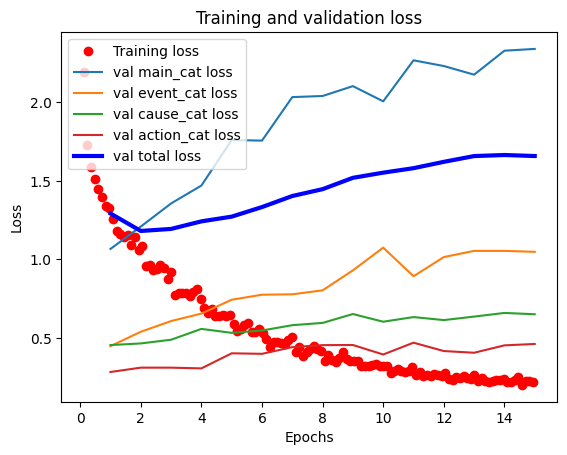

In [74]:
# Graph Training Loss
train_loss = epochHistory['train']['loss']
train_epoch = epochHistory['train']['epoch']
val_loss = epochHistory['val']['eval_loss']
val_epoch = epochHistory['val']['epoch']



# "ro" is for "red dot"
plt.plot(train_epoch, train_loss, 'ro', label='Training loss')

for key, value in epochHistory['val'].items():
  if not key.endswith('metrics'):
    continue
  title = re.findall(r'eval_(.*)_',key)[0]
  #get values into a single dict
  concatenated_dict = {}
  for dictionary in epochHistory['val'][key]:
      for key, value in dictionary.items():
          if key not in concatenated_dict:
              concatenated_dict[key] = []
          concatenated_dict[key].append(value)
  valCategories_f1 = concatenated_dict['loss']
  plt.plot(val_epoch, valCategories_f1, label=f'val {title}_cat loss')

plt.plot(val_epoch, val_loss, 'b', linewidth=3, label='val total loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

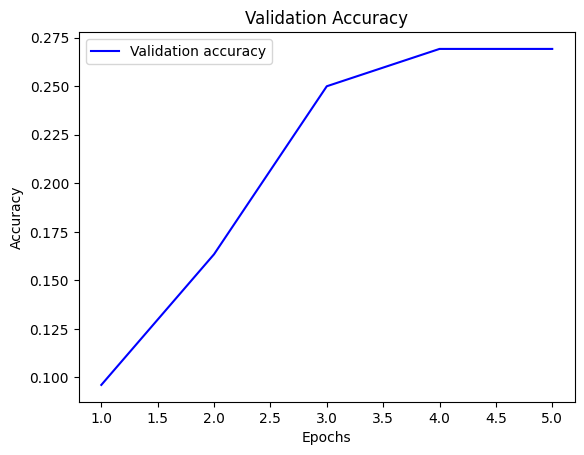

In [65]:
# train_loss = epochHistory['train']['loss']
# train_epoch = epochHistory['train']['epoch']
val_acc = epochHistory['val']['eval_accuracy']
val_epoch = epochHistory['val']['epoch']


# b is for "solid blue line"
plt.plot(val_epoch, val_acc, 'b', label='Validation accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

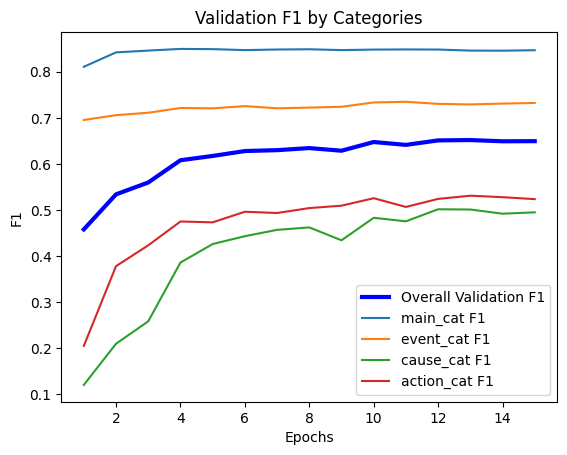

In [75]:
epochHistory['val'].keys()
import re

val_f1 = epochHistory['val']['eval_f1']
val_epoch = epochHistory['val']['epoch']
plt.plot(val_epoch, val_f1, 'b', linewidth=3, label='Overall Validation F1')

for key, value in epochHistory['val'].items():
  if not key.endswith('metrics'):
    continue
  title = re.findall(r'eval_(.*)_',key)[0]
  #get values into a single dict
  concatenated_dict = {}
  for dictionary in epochHistory['val'][key]:
      for key, value in dictionary.items():
          if key not in concatenated_dict:
              concatenated_dict[key] = []
          concatenated_dict[key].append(value)
  valCategories_f1 = concatenated_dict['f1']
  plt.plot(val_epoch, valCategories_f1, label=f'{title}_cat F1')


plt.title('Validation F1 by Categories')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend()

plt.show()

#### Multiple Model Version Investigation 


For checking different variations of the same model, like if you change the weight decay or learning rate and want to compare between them based on the trained models <br>
NOTE, may need to be optimized for the heirarchical model


In [51]:
# Optional, Reinitialize pathways shown above (copied and pasted, you must CHANGE if they do not match)
model_name = "HRAF_MultiLabel_SubClasses_Kfolds"
path = f"" #Path to centralized file locations
model_folder = "Model_4_WeightByLearning" #this is where the output folders will be created and where a centralized model is made.
model_path = f"{path}{model_folder}"



# Get list of models through common directory
files_dir = [
    f for f in os.listdir(model_path) if os.path.isdir(os.path.join(model_path, f))
]

### OPTIONAL CHANGE
# Redo the text for the file names to better fit graphs (feel free to comment out)
def lowNum(text):
    startText =  'Learning_Rate_'
    regx = fr'{startText}([a-zA-Z0-9\.\-]+)'
    num = re.findall(regx,text)[0]
    return float(num)
files_dir.sort(reverse=True, key=lowNum)



epochHistory_dict = {}
for file in files_dir:

    history_path = f"{model_path}/{file}"
    f = open(history_path+"/HistoryLog.json")
    history_list = json.load(f)
    f.close()
    epochHistory= epochDictCreator(history_list)
    epochHistory_dict[file] = epochHistory
    


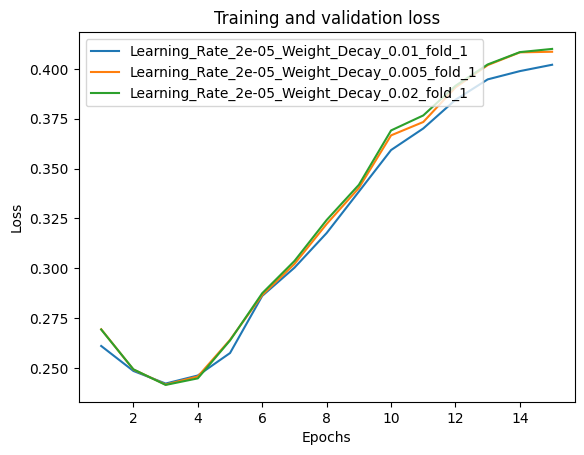

In [52]:
# Show Validation error rate
for key, epochHistory in epochHistory_dict.items():
    val_loss = epochHistory['val']['eval_loss']
    val_epoch = epochHistory['val']['epoch']
    plt.plot(val_epoch, val_loss, label=key)
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

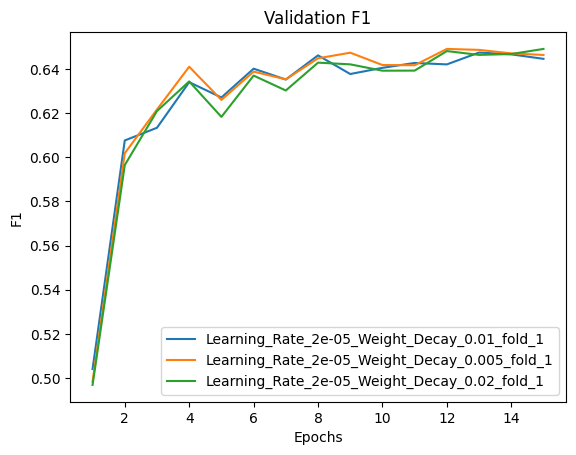

In [53]:
# Show F1 score improvements
for key, epochHistory in epochHistory_dict.items():
    val_f1 = epochHistory['val']['eval_f1']
    val_epoch = epochHistory['val']['epoch']
    plt.plot(val_epoch, val_f1, label=key)
plt.title('Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend()
plt.show()